In [1]:
# 1. imports and setup
import pandas as pd
import numpy as np
import string
import json
import re
from bs4 import BeautifulSoup
import spacy
from nltk.corpus import stopwords
import warnings
from multiprocessing import Pool, cpu_count
from functools import partial
import joblib
from tqdm import tqdm
import logging
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')
print(f"using {cpu_count()} CPU cores for parallel processing.")

using 4 CPU cores for parallel processing.


In [2]:
# 2. configuration parameters
CONFIG = {
    'target_conditions': [
        'Birth Control', 'Depression', 'Pain', 'Acne', 'Anxiety', 'Insomnia', 
        'Weight Loss', 'ADHD', 'Obesity', 'Emergency Contraception', 'High Blood Pressure', 
        'Bowel Preparation', 'Migraine', 'Smoking Cessation', 'Urinary Tract Infection', 
        'Constipation', 'Chronic Pain', 'Osteoarthritis', 'Muscle Spasm', 'Opiate Dependence',
        'Irritable Bowel Syndrome', 'Allergic Rhinitis', 'Sinusitis', 'GERD', 
        'Rheumatoid Arthritis', 'Restless Legs Syndrome', 'Cough', 'Hyperhidrosis', 
        'High Cholesterol', 'Back Pain', 'Bronchitis', 'Hepatitis C', 'Rosacea', 
        'Schizophrenia', 'Psoriasis', 'Multiple Sclerosis', 'Endometriosis', 
        'Benign Prostatic Hyperplasia', 'Bacterial Vaginitis', 'Chlamydia Infection', 
        'Headache', 'Seizures', 'Influenza', 'Atrial Fibrillation', 'Epilepsy', 'Asthma'
    ],
    'tfidf_params': {
        'sublinear_tf': True,
        'min_df': 1,
        'norm': 'l2',
        'encoding': 'latin-1',
        'ngram_range': (1, 2),
        'stop_words': 'english',
        'max_df': 0.85,
        'max_features': 20000
    },
    'cv_folds': 5,
    'random_state': 42,
    'n_jobs': -1
}

# parameter distributions
PARAM_DISTRIBUTIONS = {
    'naive_bayes': {
        'alpha': [0.1],
        'fit_prior': [False]
    },
    'passive_aggressive': {
        'C': [0.05],
        'loss': ['squared_hinge'],
        'max_iter': [50]
    },
    'logistic_regression': {
        'C': [20],
        'penalty': ['l2'],
        'solver': ['lbfgs'],
        'max_iter': [800]
    }
}

print("configuration loaded successfully!")

configuration loaded successfully!


In [3]:
# 3. data loading and validation
def validate_dataset(df, dataset_name):
    # validate dataset integrity
    assert not df.empty, f"{dataset_name} dataset is empty"
    assert 'condition' in df.columns, f"missing condition column in {dataset_name}"
    assert 'review' in df.columns, f"missing review column in {dataset_name}"
    print(f"{dataset_name} validation passed: {df.shape[0]} rows, {df.shape[1]} columns")

def clean_data_advanced(df, dataset_name):
    # remove duplicates based on review text and condition
    print(f"{dataset_name} - before duplicate removal: {df.shape[0]} samples")
    df = df.drop_duplicates(subset=['review', 'condition'], keep='first')
    print(f"{dataset_name} - after duplicate removal: {df.shape[0]} samples")
    
    # remove outliers based on text length
    df['text_length'] = df['review'].str.len()
    q1 = df['text_length'].quantile(0.05)
    q3 = df['text_length'].quantile(0.95)
    
    print(f"{dataset_name} - text length range: {q1:.0f} - {q3:.0f} characters")
    df_filtered = df[(df['text_length'] >= q1) & (df['text_length'] <= q3)]
    print(f"{dataset_name} - after outlier removal: {df_filtered.shape[0]} samples")
    
    return df_filtered.drop('text_length', axis=1)

# load datasets
df_train = pd.read_table('/kaggle/input/diseases-drugs-raw-data/train_raw.tsv', dtype=str)
df_test = pd.read_table('/kaggle/input/diseases-drugs-raw-data/test_raw.tsv', dtype=str)

print(f"original train dataset shape: {df_train.shape}")
print(f"original test dataset shape: {df_test.shape}\n")

# remove unnecessary columns
unused_cols = ['Unnamed: 0', 'drugName', 'rating', 'date', 'usefulCount']
df_train = df_train.drop(columns=[col for col in unused_cols if col in df_train.columns])
df_test = df_test.drop(columns=[col for col in unused_cols if col in df_test.columns])

# filter for target conditions and remove missing values
df_train = df_train[df_train['condition'].isin(CONFIG['target_conditions'])]
df_train = df_train.dropna()
df_test = df_test[df_test['condition'].isin(CONFIG['target_conditions'])]
df_test = df_test.dropna()

# apply cleaning to both datasets
df_train_clean = clean_data_advanced(df_train, "train")
df_test_clean = clean_data_advanced(df_test, "test")

# validate cleaned datasets
print("\n")
validate_dataset(df_train_clean, "train")
validate_dataset(df_test_clean, "test")

print(f"\nfinal train dataset: {df_train_clean.shape}")
print(f"final test dataset: {df_test_clean.shape}")

original train dataset shape: (161297, 7)
original test dataset shape: (53766, 7)

train - before duplicate removal: 103424 samples
train - after duplicate removal: 71061 samples
train - text length range: 88 - 772 characters
train - after outlier removal: 64191 samples
test - before duplicate removal: 34713 samples
test - after duplicate removal: 31018 samples
test - text length range: 88 - 772 characters
test - after outlier removal: 28038 samples


train validation passed: 64191 rows, 2 columns
test validation passed: 28038 rows, 2 columns

final train dataset: (64191, 2)
final test dataset: (28038, 2)


In [4]:
# 4. parallel text preprocessing functions
def clean_single_text(text):
    # single text cleaning function - must be at module level for multiprocessing
    # remove html tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    # remove quotes and non-alphabetic characters  
    text = str(text).replace('"', '')
    text = re.sub('[^a-zA-Z]', ' ', text)
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in text.split() if word.lower() not in stop_words]
    # remove punctuation
    text = ' '.join(words)
    text = ''.join([char for char in text if char not in string.punctuation])
    return text.lower().strip()

def parallel_text_cleaning(texts, n_processes=None):
    # parallel text preprocessing for improved speed
    if n_processes is None:
        n_processes = min(cpu_count(), 4) # limit processes to avoid memory issues
    
    with Pool(processes=n_processes) as pool:
        cleaned_texts = list(tqdm(pool.imap(clean_single_text, texts), total=len(texts), desc="cleaning texts"))
    
    return cleaned_texts

def extract_text_features(texts):
    # extract additional text features
    features = pd.DataFrame()
    features['text_length'] = [len(text) for text in texts]
    features['word_count'] = [len(text.split()) for text in texts]
    features['avg_word_length'] = [np.mean([len(word) for word in text.split()]) if text.split() else 0 for text in texts]
    return features

print("preprocessing functions loaded!")

preprocessing functions loaded!


starting text preprocessing...


cleaning texts: 100%|██████████| 28038/28038 [00:05<00:00, 4881.51it/s]



extracted 3 additional text features

sample original review: "My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he wi...

sample cleaned review: son halfway fourth week intuniv became concerned began last week started taking highest dose two days could hardly get bed cranky slept nearly hours d...



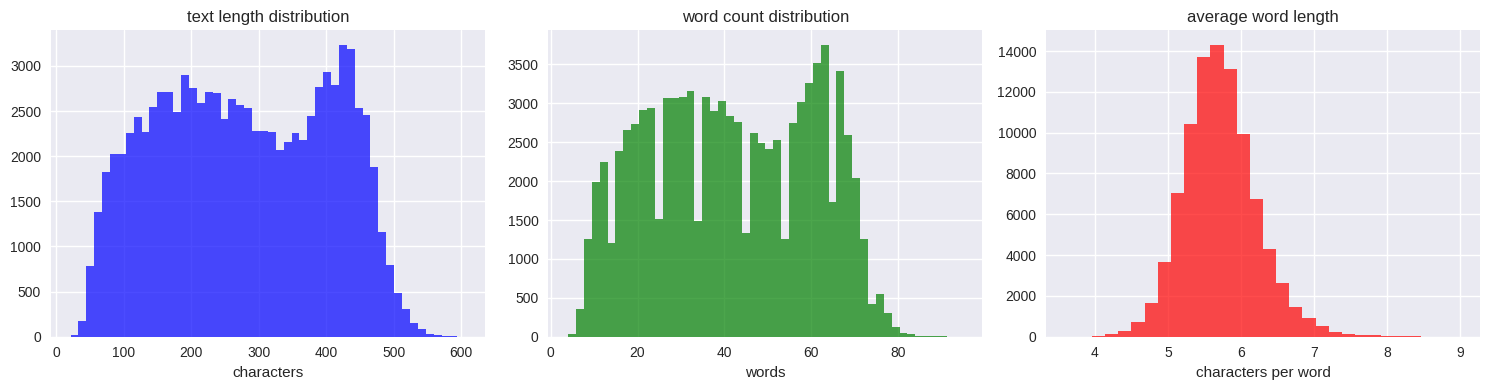

training set: 64191 samples
testing set: 28038 samples
unique conditions: 46


In [5]:
# 5. apply text preprocessing
print("starting text preprocessing...")

# preprocess text data
df_train_clean['cleaned_review'] = parallel_text_cleaning(df_train_clean['review'].tolist())
df_test_clean['cleaned_review'] = parallel_text_cleaning(df_test_clean['review'].tolist())

# extract additional features
text_features_train = extract_text_features(df_train_clean['cleaned_review'].tolist())
text_features_test = extract_text_features(df_test_clean['cleaned_review'].tolist())
text_features_combined = pd.concat([text_features_train, text_features_test], ignore_index=True)

print(f"\nextracted {text_features_combined.shape[1]} additional text features")

# display preprocessing results
print(f"\nsample original review: {df_train_clean['review'].iloc[0][:150]}...")
print(f"\nsample cleaned review: {df_train_clean['cleaned_review'].iloc[0][:150]}...\n")

# visualize text statistics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(text_features_combined['text_length'], bins=50, alpha=0.7, color='blue')
axes[0].set_title('text length distribution')
axes[0].set_xlabel('characters')

axes[1].hist(text_features_combined['word_count'], bins=50, alpha=0.7, color='green')
axes[1].set_title('word count distribution')
axes[1].set_xlabel('words')

axes[2].hist(text_features_combined['avg_word_length'], bins=30, alpha=0.7, color='red')
axes[2].set_title('average word length')
axes[2].set_xlabel('characters per word')

plt.tight_layout()
plt.show()

# prepare final data splits
X_train = df_train_clean['cleaned_review']
y_train = df_train_clean['condition']
X_test = df_test_clean['cleaned_review']
y_test = df_test_clean['condition']

print(f"training set: {len(X_train)} samples")
print(f"testing set: {len(X_test)} samples")
print(f"unique conditions: {y_train.nunique()}")

In [6]:
# 6. model training pipeline
class ModelTrainer:
    def __init__(self, config):
        self.config = config
        self.models = {}
        self.results = {}
        self.vectorizer = None
        
    def create_models(self):
        self.models = {
            'naive_bayes': MultinomialNB(),
            'passive_aggressive': PassiveAggressiveClassifier(random_state=self.config['random_state']),
            'logistic_regression': LogisticRegression(random_state=self.config['random_state'], n_jobs=self.config['n_jobs'])
        }

    def train_models(self, X_train, X_test, y_train, y_test):
        # vectorize text data
        self.vectorizer = TfidfVectorizer(**self.config['tfidf_params'])
        X_train_vec = self.vectorizer.fit_transform(X_train)
        X_test_vec = self.vectorizer.transform(X_test)
        
        cv_strategy = StratifiedKFold(n_splits=self.config['cv_folds'], shuffle=True, random_state=self.config['random_state'])
        
        for name, model in tqdm(self.models.items(), desc="training models"):
            print(f"\ntraining {name} model:")
            
            param_grid = PARAM_DISTRIBUTIONS.get(name, {})
            
            grid_search = GridSearchCV(
                model, param_grid, cv=cv_strategy, scoring='f1_macro', 
                n_jobs=self.config['n_jobs'], verbose=0
            )
            grid_search.fit(X_train_vec, y_train)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            cv_mean = grid_search.best_score_
            cv_std = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
            
            # evaluate model
            train_pred = best_model.predict(X_train_vec)
            test_pred = best_model.predict(X_test_vec)
            
            # calculate metrics
            train_acc = accuracy_score(y_train, train_pred)
            test_acc = accuracy_score(y_test, test_pred)
            f1_macro = f1_score(y_test, test_pred, average='macro')
            f1_weighted = f1_score(y_test, test_pred, average='weighted')
            
            self.results[name] = {
                'model': best_model,
                'train_accuracy': train_acc,
                'test_accuracy': test_acc,
                'f1_macro': f1_macro,
                'f1_weighted': f1_weighted,
                'cv_mean': cv_mean,
                'cv_std': cv_std,
                'best_params': best_params,
                'test_predictions': test_pred
            }
            
        return X_train_vec, X_test_vec

# initialize trainer
trainer = ModelTrainer(CONFIG)
trainer.create_models()
print("model trainer initialized!")

model trainer initialized!


In [7]:
# 7. train models
print("training models...\n")
X_train_vec, X_test_vec = trainer.train_models(X_train, X_test, y_train, y_test)

training models...



training models:   0%|          | 0/3 [00:00<?, ?it/s]


training naive_bayes model:


training models:  33%|███▎      | 1/3 [00:04<00:09,  4.83s/it]


training passive_aggressive model:


training models:  67%|██████▋   | 2/3 [00:50<00:28, 28.85s/it]


training logistic_regression model:


training models: 100%|██████████| 3/3 [15:08<00:00, 302.78s/it]


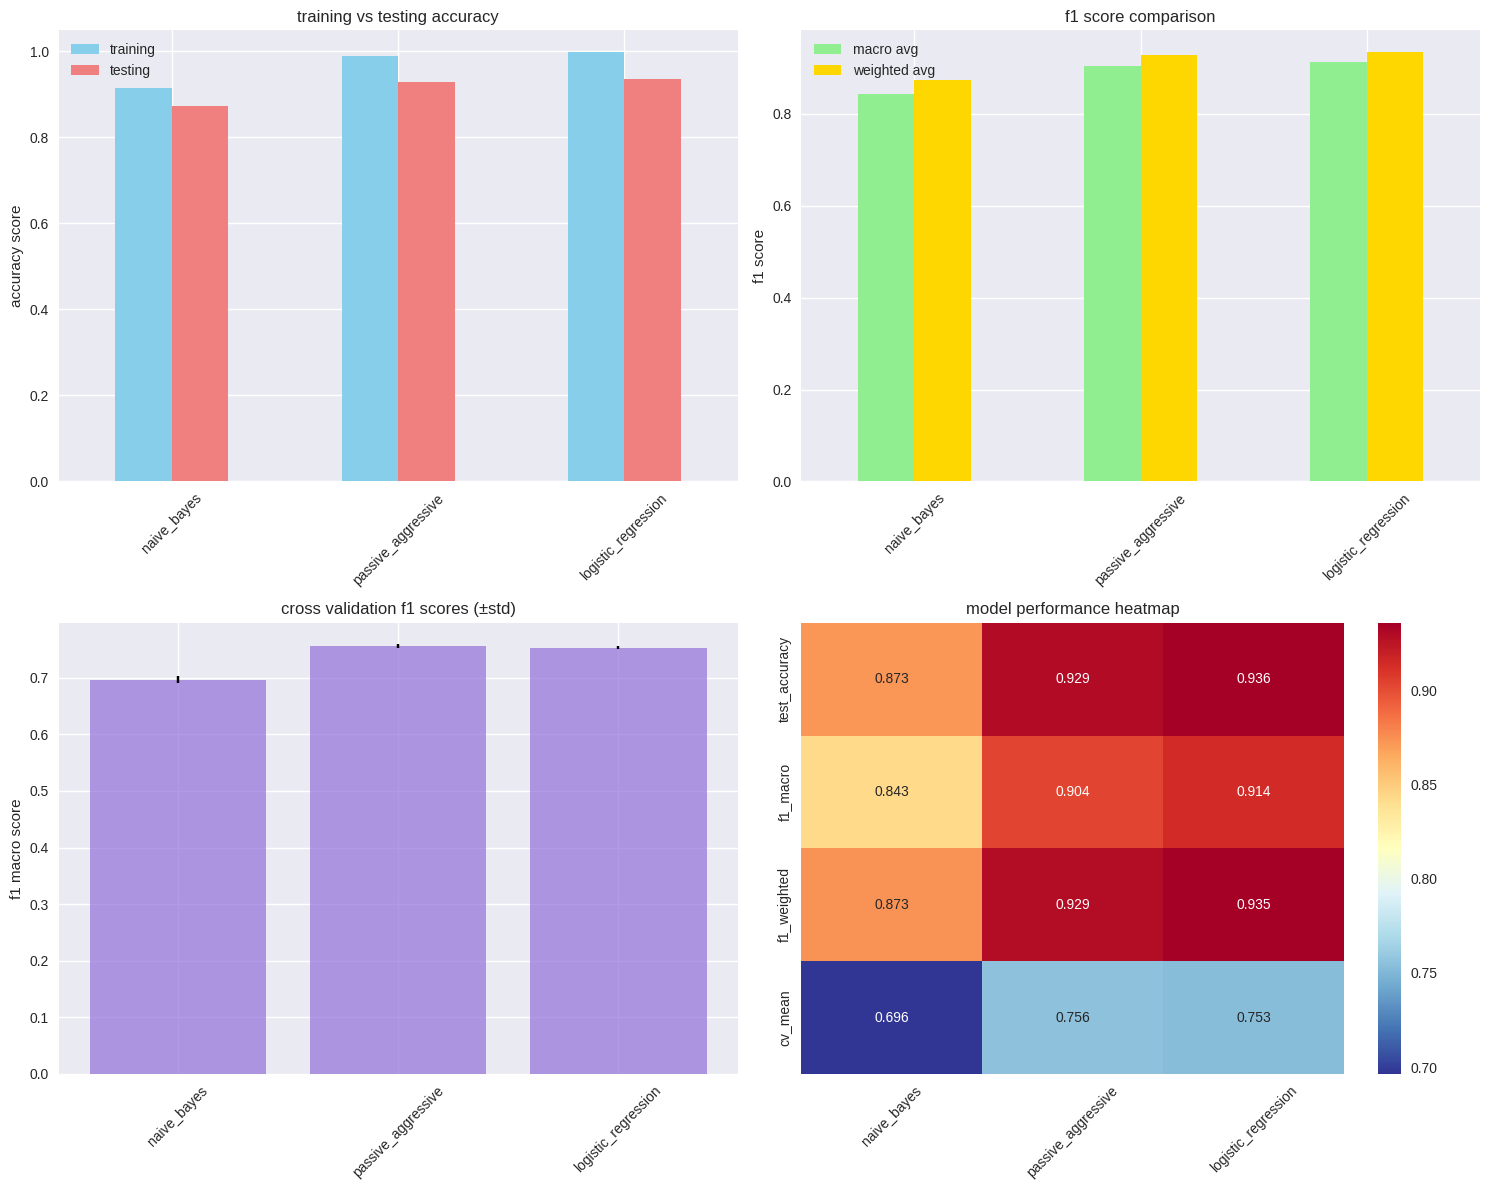

model performance summary:


,train_accuracy,test_accuracy,f1_macro,f1_weighted,cv_mean,cv_std
naive_bayes,0.9160,0.8730,0.8431,0.8731,0.6964,0.0060
passive_aggressive,0.9893,0.9292,0.9039,0.9285,0.7561,0.0031
logistic_regression,0.9992,0.9357,0.9141,0.9353,0.7530,0.0024


In [8]:
# 8. results visualization function
def create_results_dashboard(results, title_suffix=""):
    # prepare results dataframe
    results_df = pd.DataFrame({
        model_name: {
            'train_accuracy': data['train_accuracy'],
            'test_accuracy': data['test_accuracy'], 
            'f1_macro': data['f1_macro'],
            'f1_weighted': data['f1_weighted'],
            'cv_mean': data['cv_mean'],
            'cv_std': data['cv_std']
        }
        for model_name, data in results.items()
    }).T
    
    # visualization dashboard
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # accuracy comparison
    results_df[['train_accuracy', 'test_accuracy']].plot(kind='bar', ax=axes[0,0], color=['skyblue', 'lightcoral'])
    axes[0,0].set_title(f'training vs testing accuracy{title_suffix}')
    axes[0,0].set_ylabel('accuracy score')
    axes[0,0].legend(['training', 'testing'])
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # f1 scores comparison
    results_df[['f1_macro', 'f1_weighted']].plot(kind='bar', ax=axes[0,1], color=['lightgreen', 'gold'])
    axes[0,1].set_title(f'f1 score comparison{title_suffix}') 
    axes[0,1].set_ylabel('f1 score')
    axes[0,1].legend(['macro avg', 'weighted avg'])
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # cross validation scores with error bars
    cv_data = results_df[['cv_mean', 'cv_std']]
    axes[1,0].bar(cv_data.index, cv_data['cv_mean'], yerr=cv_data['cv_std'], capsize=5, color='mediumpurple', alpha=0.7)
    axes[1,0].set_title(f'cross validation f1 scores (±std){title_suffix}')
    axes[1,0].set_ylabel('f1 macro score')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # model performance heatmap
    heatmap_data = results_df[['test_accuracy', 'f1_macro', 'f1_weighted', 'cv_mean']]
    sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='RdYlBu_r', ax=axes[1,1])
    axes[1,1].set_title(f'model performance heatmap{title_suffix}')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# visualize results
results_df = create_results_dashboard(trainer.results)
print("model performance summary:")
results_df.round(4)

In [9]:
# 9. display the best parameters for corresponding test accuracy of the models
print("best parameters for each model (based on test accuracy):\n")

for model_name, results in trainer.results.items():
    print(f"{model_name.upper()}:")
    print(f"  test accuracy: {results['test_accuracy']:.4f}")
    print(f"  parameters: {results['best_params']}")
    print()

# overall best model
best_model_name = max(trainer.results.keys(), key=lambda x: trainer.results[x]['test_accuracy'])
best_accuracy = trainer.results[best_model_name]['test_accuracy']

print(f"overall best model: {best_model_name} (test accuracy: {best_accuracy:.4f})")

best parameters for each model (based on test accuracy):

NAIVE_BAYES:
  test accuracy: 0.8730
  parameters: {'alpha': 0.1, 'fit_prior': False}

PASSIVE_AGGRESSIVE:
  test accuracy: 0.9292
  parameters: {'C': 0.05, 'loss': 'squared_hinge', 'max_iter': 50}

LOGISTIC_REGRESSION:
  test accuracy: 0.9357
  parameters: {'C': 20, 'max_iter': 800, 'penalty': 'l2', 'solver': 'lbfgs'}

overall best model: logistic_regression (test accuracy: 0.9357)


In [10]:
# 10. stacking ensemble
print("creating stacking ensemble...\n")

# select best individual model
best_model_name = results_df['test_accuracy'].idxmax()
best_model_info = trainer.results[best_model_name]

print(f"best individual model: {best_model_name}")
print(f"cv f1 score: {best_model_info['cv_mean']:.4f} ± {best_model_info['cv_std']:.4f}")
print(f"test accuracy: {best_model_info['test_accuracy']:.4f}")

# create stacking ensemble
base_estimators = [(name, trainer.results[name]['model']) for name in trainer.results.keys()]
stacking_classifier = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(random_state=CONFIG['random_state']),
    cv=5,
    n_jobs=CONFIG['n_jobs']
)

stacking_classifier.fit(X_train_vec, y_train)

# evaluate stacking ensemble
stacking_train_pred = stacking_classifier.predict(X_train_vec)
stacking_test_pred = stacking_classifier.predict(X_test_vec)
stacking_train_acc = accuracy_score(y_train, stacking_train_pred)
stacking_test_acc = accuracy_score(y_test, stacking_test_pred)
stacking_f1 = f1_score(y_test, stacking_test_pred, average='macro')

print("\nstacking ensemble results:\n")
print(f"train accuracy: {stacking_train_acc:.4f}")
print(f"test accuracy: {stacking_test_acc:.4f}")
print(f"f1 macro: {stacking_f1:.4f}")

# select best model
if stacking_test_acc > best_model_info['test_accuracy']:
    final_model = stacking_classifier
    final_model_name = 'stacking_ensemble'
    final_accuracy = stacking_test_acc
    final_predictions = stacking_test_pred
else:
    final_model = best_model_info['model']
    final_model_name = best_model_name
    final_accuracy = best_model_info['test_accuracy']
    final_predictions = best_model_info['test_predictions']

print(f"\nfinal best model: {final_model_name} (accuracy: {final_accuracy:.4f})")

creating stacking ensemble...

best individual model: logistic_regression
cv f1 score: 0.7530 ± 0.0024
test accuracy: 0.9357

stacking ensemble results:

train accuracy: 0.9794
test accuracy: 0.9264
f1 macro: 0.9062

final best model: logistic_regression (accuracy: 0.9357)


In [11]:
# 11. model persistence and prediction system
print("saving final model and creating prediction system...\n")

# save model and vectorizer
model_filename = f'medical_condition_predictor_{final_model_name}.pkl'
vectorizer_filename = 'tfidf_vectorizer.pkl'

joblib.dump(final_model, model_filename)
joblib.dump(trainer.vectorizer, vectorizer_filename)
print(f"model saved as: {model_filename}")
print(f"vectorizer saved as: {vectorizer_filename}")

def predict_condition_with_confidence(model, vectorizer, text_input):
    # input validation
    if not text_input or not text_input.strip():
        return {'error': 'empty input text'}
    
    # clean text using existing function
    cleaned_text = clean_single_text(text_input)
    
    if not cleaned_text.strip():
        return {'error': 'input contains no valid text after cleaning'}
    
    # vectorize and predict
    text_vectorized = vectorizer.transform([cleaned_text])
    prediction = model.predict(text_vectorized)[0]
    
    # get confidence scores if available
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(text_vectorized)[0]
        confidence = max(probabilities)
        top_3_indices = probabilities.argsort()[-3:][::-1]
        top_3_conditions = [model.classes_[i] for i in top_3_indices]
        top_3_probs = [probabilities[i] for i in top_3_indices]
    else:
        confidence = None
        top_3_conditions = [prediction]
        top_3_probs = [None]
    
    return {
        'prediction': prediction,
        'confidence': confidence,
        'top_3_predictions': list(zip(top_3_conditions, top_3_probs)),
        'cleaned_input': cleaned_text
    }

print("\nprediction system ready!")

saving final model and creating prediction system...

model saved as: medical_condition_predictor_logistic_regression.pkl
vectorizer saved as: tfidf_vectorizer.pkl

prediction system ready!


In [12]:
# 12. comprehensive testing and demonstration
test_cases = [
    {'text': """I have severe anxiety panic disorder started when I was a child. 
                I have been taking xanax for over 30 years now. Everyday 4 pills really bad days 
                I was taking 6 pills. I have extreme insomnia, anxiety and extreme panic attacks 
                that plague me everyday. Some people really do need xanax""", 'expected': 'Anxiety'},
    {'text': """I suffer from chronic back pain after a car accident. The pain is constant 
                and makes it difficult to work or sleep. Physical therapy hasn't helped much. 
                I need something stronger for pain management.""", 'expected': 'Back Pain'},
    {'text': """Started having severe headaches that last for hours. They come with nausea 
                and sensitivity to light. Nothing seems to help except staying in a dark room. 
                These episodes are becoming more frequent.""", 'expected': 'Migraine'},
    {'text': """I've been struggling with depression for months now. Feel hopeless and tired all the time.
                Nothing interests me anymore and I can barely get out of bed. My doctor suggested 
                antidepressants but I'm worried about side effects.""", 'expected': 'Depression'},
    {'text': """Having trouble sleeping for weeks. Toss and turn all night, mind racing with thoughts.
                Even when exhausted, can't fall asleep. Tried melatonin but doesn't help much.
                This is affecting my work performance.""", 'expected': 'Insomnia'},
    {'text': """Been having stomach issues and irregular bowel movements. Sometimes constipated,
                sometimes loose stools. Cramping and bloating after meals. Stress seems to make it worse.
                Doctor mentioned it might be related to my gut.""", 'expected': 'Irritable Bowel Syndrome'},
    {'text': """My joints are swollen and painful, especially in the morning. Stiffness lasts for hours.
                Both hands and knees are affected. Anti-inflammatory drugs help but not completely.
                Blood tests show elevated inflammation markers.""", 'expected': 'Rheumatoid Arthritis'},
    {'text': """Persistent cough that won't go away for over two weeks. Sometimes brings up phlegm.
                Chest feels tight and breathing is slightly difficult. No fever but feel run down.
                Cough drops and syrups haven't helped.""", 'expected': 'Bronchitis'}
]

print("model prediction demonstration:")
correct_predictions = 0

for i, test_case in enumerate(test_cases, 1):
    result = predict_condition_with_confidence(final_model, trainer.vectorizer, test_case['text'])
    
    print(f"\ntest case {i}:")
    print(f"input text: {test_case['text'][:150]}...")
    print(f"\nexpected condition: {test_case['expected']}")
    
    if 'error' in result:
        print(f"prediction error: {result['error']}")
        continue
        
    print(f"predicted condition: {result['prediction']}")
    
    if result['confidence']:
        print(f"confidence: {result['confidence']:.3f}")
        print("top 3 predictions:")
        for j, (condition, prob) in enumerate(result['top_3_predictions'], 1):
            if prob is not None:
                print(f"  {j}. {condition}: {prob:.3f}")
            else:
                print(f"  {j}. {condition}: n/a")
    
    if result['prediction'] == test_case['expected']:
        correct_predictions += 1
        print("correct prediction!")
    else:
        print("incorrect prediction!")

demo_accuracy = correct_predictions / len(test_cases)
print(f"\ndemonstration accuracy: {demo_accuracy:.3f} ({correct_predictions}/{len(test_cases)})")

model prediction demonstration:

test case 1:
input text: I have severe anxiety panic disorder started when I was a child. 
                I have been taking xanax for over 30 years now. Everyday 4 pills rea...

expected condition: Anxiety
predicted condition: Anxiety
confidence: 0.997
top 3 predictions:
  1. Anxiety: 0.997
  2. Depression: 0.001
  3. Birth Control: 0.001
correct prediction!

test case 2:
input text: I suffer from chronic back pain after a car accident. The pain is constant 
                and makes it difficult to work or sleep. Physical therapy ...

expected condition: Back Pain
predicted condition: Chronic Pain
confidence: 0.622
top 3 predictions:
  1. Chronic Pain: 0.622
  2. Pain: 0.227
  3. Back Pain: 0.146
incorrect prediction!

test case 3:
input text: Started having severe headaches that last for hours. They come with nausea 
                and sensitivity to light. Nothing seems to help except sta...

expected condition: Migraine
predicted condition: Depre

In [13]:
# 13. comprehensive final summary
print("comprehensive summary...\n")

# dataset summary
dataset_summary = pd.DataFrame({
    'metric': [
        'original train samples (after duplicate removal)',
        'original test samples (after duplicate removal)', 
        'cleaned train samples',
        'cleaned test samples (finalized samples)',
        'total cleaned samples (finalized samples)',
        'target conditions',
        'avg samples per condition',
        'min condition samples',
        'max condition samples'
    ],
    'value': [
        df_train.shape[0],
        df_test.shape[0],
        len(X_train),
        len(X_test),
        len(X_train) + len(X_test),
        len(CONFIG['target_conditions']),
        round((len(X_train) + len(X_test)) / len(CONFIG['target_conditions']), 1),
        min(y_train.value_counts().min(), y_test.value_counts().min()),
        max(y_train.value_counts().max(), y_test.value_counts().max())
    ]
})

print("dataset summary:\n")
print(dataset_summary.to_string(index=False))

# comprehensive model comparison
all_results = []

# individual models
for name, data in trainer.results.items():
    all_results.append({
        'model': name,
        'test_accuracy': data['test_accuracy'],
        'f1_macro': data['f1_macro'],
        'cv_mean': data['cv_mean']
    })

# stacking ensemble
all_results.append({
    'model': 'stacking_ensemble',
    'test_accuracy': stacking_test_acc,
    'f1_macro': stacking_f1,
    'cv_mean': 'n/a'
})

results_comparison_df = pd.DataFrame(all_results)
results_comparison_df = results_comparison_df.round(4)
results_sorted = results_comparison_df.sort_values('test_accuracy', ascending=False)

print("\nall models ranked by test accuracy:\n")
print(results_sorted.to_string(index=False))

# final model summary
print("\n\nfinal model summary:\n")
print(f"- selected model: {final_model_name}")
print(f"- test accuracy: {final_accuracy:.4f}")
print(f"- f1 macro score: {f1_score(y_test, final_predictions, average='macro'):.4f}")
print(f"- f1 weighted score: {f1_score(y_test, final_predictions, average='weighted'):.4f}")
print(f"- demonstration accuracy: {demo_accuracy:.3f}")

print(f"\nmodel files saved:\n")
print(f"- {model_filename}")
print(f"- {vectorizer_filename}")

comprehensive summary...

dataset summary:

                                          metric    value
original train samples (after duplicate removal) 103424.0
 original test samples (after duplicate removal)  34713.0
                           cleaned train samples  64191.0
        cleaned test samples (finalized samples)  28038.0
       total cleaned samples (finalized samples)  92229.0
                               target conditions     46.0
                       avg samples per condition   2005.0
                           min condition samples     61.0
                           max condition samples  16793.0

all models ranked by test accuracy:

              model  test_accuracy  f1_macro   cv_mean
logistic_regression         0.9357    0.9141  0.753024
 passive_aggressive         0.9292    0.9039  0.756129
  stacking_ensemble         0.9264    0.9062       n/a
        naive_bayes         0.8730    0.8431  0.696435


final model summary:

- selected model: logistic_regression
-